In [1]:
%matplotlib inline
import numpy as np
from scipy import stats
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from pprint import pprint
import pandas as pd
import yaml, os
import cv2 as cv

from os import listdir
from os.path import isfile, join

import dac
from plotting import dict_format

In [3]:
plt.rcParams['figure.figsize'] = (6,6)
plt.rcParams.update({'font.size': 12})

<h1>Bandgap</h1>

In [ ]:
fname = '../../data/testing/20220223_132341_bandgap_10800x.csv'

# Reading by rows
df = pd.read_csv(fname, header=None).set_index(0).T

In [ ]:
teensy_vec = np.array(df['Teensy Internal Temp'])
temp_vec = np.array(df['TMP102'])
chamber_vec = np.array(df['Chamber'])
vbg_vec = np.array(df['Bandgap (V)'])

In [ ]:
### Bandgap voltage plotting
# plt.scatter(teensy_vec, vbg_vec, alpha=0.5, label='Teensy Internal')
# plt.scatter(chamber_vec, vbg_vec, alpha=0.5, label='Chamber Readout')
plt.scatter(chamber_vec, vbg_vec, label='Chamber Readout')
# plt.scatter(temp_vec, vbg_vec, alpha=0.5, label='TMP102')

# plt.legend()
plt.grid(True)
plt.ylabel('Bandgap Voltage (V)');
plt.xlabel('Temperature (C)');

print(f'Bandgap Voltage Range: {max(vbg_vec)-min(vbg_vec)}')

idx_roomtemp = np.argwhere(np.diff(np.sign(chamber_vec-27))).flatten()
vout_roomtemp = vbg_vec[idx_roomtemp][0]
plt.figure()
plt.plot(chamber_vec, (vbg_vec-vout_roomtemp)/vout_roomtemp*100)
plt.xlabel('Temperature (C)')
plt.ylabel('Voltage % Variation\n(vs. Room Temp)')
plt.grid(True)

In [ ]:
vbg_hist, vbg_bins_raw = np.histogram(vbg_vec, bins=100)
vbg_bins = 0.5*(vbg_bins_raw[1:] + vbg_bins_raw[:-1])
plt.plot(vbg_bins, vbg_hist)
plt.xlabel('Bandgap Voltage (V)')
plt.ylabel('Count')
plt.grid(True)

In [ ]:
### Temp Comparison Plotting
# Histogram
n_bins = 100

teensy_hist, teensy_bins_raw = np.histogram(teensy_vec, bins=n_bins)
chamber_hist, chamber_bins_raw = np.histogram(chamber_vec, bins=n_bins)
# temp_hist, temp_bins_raw = np.histogram(temp_vec, bins=n_bins)

teensy_bins = 0.5*(teensy_bins_raw[1:] + teensy_bins_raw[:-1])
chamber_bins = 0.5*(chamber_bins_raw[1:] + chamber_bins_raw[:-1])
# temp_bins = 0.5*(temp_bins_raw[1:] + temp_binw_raw[:-1])

plt.plot(teensy_bins, teensy_hist, label='Teensy Internal')
plt.plot(chamber_bins, chamber_hist, label='Chamber Readout')
# plt.plot(temp_bins, temp_hist, label='TMP102')

plt.legend()
plt.grid(True)
plt.xlabel('Temperature (C)')
plt.ylabel('Count')

In [ ]:
# Temp Differences
plt.plot(teensy_vec, label='Teensy Internal')
plt.plot(chamber_vec, label='Chamber Readout')
# plt.plot(temp_vec, label='TMP102')
plt.xlabel('Sample')
plt.ylabel('Temperature (C)')
plt.legend()
plt.grid(True)

plt.figure()
plt.plot(teensy_vec-chamber_vec, label='Teensy Internal - Chamber Readout')
plt.xlabel('Sample')
plt.ylabel('Teensy-Chamber (C)')
plt.grid(True)

In [ ]:
# 

<h1>Resistive DAC</h1>

In [ ]:
plt.rcParams['figure.figsize'] = (6,2.5)
plt.rcParams.update({'font.size': 12})

<h2>INL/DNL</h2>

In [ ]:
# fname = '../../data/testing/20220225_135703_dac0_1000x.csv'
fname = '../../data/testing/20220225_151239_dac1_1000x.csv'
num_iter = 1000

# Reading by rows
df = pd.read_csv(fname, header=None, names=['Code']+[f'Iteration {x}' for x in range(1,num_iter+1)])

code_data_dict = dict()
for row in df.itertuples(index=False):
    code = 255-int(row[0]) # Backwards codes, whoops...
    data = row[1:]
    code_data_dict[code] = data

In [ ]:
code_max = max(code_data_dict.keys())
code_min = min(code_data_dict.keys())
print(f'Range: {np.mean(code_data_dict[code_min])}, {np.mean(code_data_dict[code_max])}')

In [ ]:
code_vec = code_data_dict.keys()
avg_vec = [np.mean(code_data_dict[code]) for code in code_vec]
gain = dac.calc_gain(code_data_dict)
vfsr = dac.calc_fsr(code_data_dict)

plt.plot(code_vec, avg_vec)
plt.xlabel('Code')
plt.ylabel('DAC Voltage (V)')
plt.grid(True)
plt.title(f'VFSR: {round(vfsr*1e3, 2)} mV\nGain: {round(gain*1e3, 2)} mV/LSB');
# plt.annotate(f'FSR: {vfsr}V\nGain: {gain}V/LSB', (0,0))

In [ ]:
# Plotting DNL and INL
dnl_dict = dac.calc_dnl(code_data_dict)
code_vec, dnl_vec = dict_format(dnl_dict)
plt.plot(code_vec, dnl_vec)
plt.xlabel('Code')
plt.ylabel('DNL')
plt.grid(True)
plt.title(f'Min/Max DNL: {round(min(dnl_vec), 2)}/{round(max(dnl_vec), 2)}');
# plt.axhline(y=-1, color='r', linestyle='-')
# plt.axhline(y=1, color='r', linestyle='-')

plt.figure()
inl_dict = dac.calc_inl(code_data_dict)
code_vec, inl_vec = dict_format(inl_dict)
plt.plot(code_vec, inl_vec)
plt.xlabel('Code')
plt.ylabel('INL')
plt.grid(True)
plt.title(f'Min/Max INL: {round(min(inl_vec), 2)}/{round(max(inl_vec), 2)}');

In [ ]:
code_noise_dict = dac.calc_noise(code_data_dict)
code_vec, noise_vec = dict_format(code_noise_dict)
plt.plot(code_vec, [1e3*x for x in noise_vec])
plt.xlabel('Code')
plt.ylabel('RMS Noise (mV)')
plt.grid(True)
plt.title(f'Max RMS Noise: {round(max(noise_vec)*1e3, 2)} mV')

<h1>Peak Detector</h1>

In [ ]:
file_in = '../../data/testing/20220303_181854_pk_200x.yaml'
with open(file_in, 'r') as f:
    data_dict = yaml.load(f, Loader=yaml.FullLoader)

In [ ]:
plt.rcParams['figure.figsize'] = (4,3)
plt.rcParams.update({'font.size': 12})

In [ ]:
vin_ideal_vec = data_dict['ideal']
vin_real_vec = data_dict['real']
vout_raw = data_dict['output']
vout_avg_vec = [np.mean(vout_vec) for vout_vec in vout_raw]
vout_std_vec = [np.std(vout_vec) for vout_vec in vout_raw]
vout_avg_err_vec = np.array([vout_avg_vec[i]-vin_real_vec[i] for i,_ in enumerate(vin_real_vec)])

In [ ]:
plt.plot(vin_real_vec, vout_avg_vec, label='Data')
plt.plot(vin_real_vec, vin_real_vec, label='Ideal')
plt.grid(True)
plt.legend()
plt.xlabel('Input Voltage (V)');
plt.ylabel('Peak Detector Output (V)');

plt.figure()
plt.plot(vin_real_vec, vout_avg_err_vec*1e3)
plt.grid(True)
plt.xlabel('Input Voltage (V)');
plt.ylabel('Error Voltage (mV)');

plt.figure()
plt.plot(vin_real_vec, vout_std_vec)
plt.grid(True)
plt.xlabel('Input Voltage (V)');
plt.ylabel('Peak Detector Output $\sigma$ (Vrms)');

In [ ]:
# Looking at conditions with worst standard deviations
idx_max_std_vec = np.argsort(vout_std_vec)[::-1]

for i in range(6):
    idx_std = idx_max_std_vec[i]
    vin = vin_real_vec[idx_std]
    vout_data = vout_raw[idx_std]
    vout_std = vout_std_vec[idx_std]
    
    plt.figure()
    plt.plot(vout_data, color='orange')
    plt.xlabel('Sample');
    plt.ylabel('Measured Output Voltage (V)');
    plt.title(f'Input Voltage: {vin} V\n$\sigma$={vout_std} Vrms');
    plt.grid(True)

<h1>Chip Image Stitching</h1>

In [ ]:
start_path = '../../../presentations/20220315_figs/'
num_col_map = {0 : 5,
              1 : 4,
              2 : 6,
              3 : 8,
              4 : 5}

In [ ]:
for row in num_col_map.keys():
    output_file = f'{start_path}result_r{row}.jpg'
    img_names = [f'r{row}c{col}.jpg' for col in range(num_col_map[row])]
    
    print(f'Row {row}...')
    
    img_lst = []
    height = np.inf
    for img_name in img_names:
        img = cv.imread(cv.samples.findFile(f'{start_path}{img_name}'))
        if img is None:
            print(f"Can't find {img_name}")
            continue
        img_lst.append(img)
        height = min(height, img.shape[0])

    stitcher = cv.Stitcher.create(cv.Stitcher_PANORAMA)
    status, pano = stitcher.stitch(img_lst)

    if status != cv.Stitcher_OK:
        print(f"Can't stitch: {status}")
        
    pano_height = pano.shape[0]
    pano_width = pano.shape[1]
    pano_cropped = pano[pano_height-height+75:height-75, :]
    
    cv.imwrite(output_file, pano_cropped)

In [ ]:
img_names = [f'result_r{row}' for row in num_col_map.keys()]
img_lst = []
for img_name in img_names:
    print(img_name)
    img = cv.imread(cv.samples.findFile(f'{start_path}{img_name}.jpg'))
    if img is None:
        print(f"Can't find {img_name}")
        continue
    img_rot = cv.rotate(img, cv.ROTATE_90_COUNTERCLOCKWISE)
    img_lst.append(img_rot)
    cv.imwrite(f'{start_path}rot_{img_name}.jpg', img_rot)
    
stitcher = cv.Stitcher.create(cv.Stitcher_PANORAMA)
status, pano = stitcher.stitch(img_lst)

if status != cv.Stitcher_OK:
    print(f"Can't stitch: {status}")

cv.imwrite(f'{start_path}result.jpg', pano)

<h1>Small Chain ZCD Fast Testing</h1>

In [173]:
data_path = '../../data/testing/temp'

# Get all relevant files in directory
filt = lambda f: True # ('zcdSmall' in f) and ('vin' in f) and ('20220408' in f) and ('nonzero' in f)
filt_contents = lambda config: config['vin_amp'] > 0.7
file_in_vec = [f'{data_path}/{f}' for f in listdir(data_path) if (isfile(join(data_path, f))) and filt(f)]

In [198]:
# ~2ns walk from 0.7V -> 1.3V input from just the instrument
walk_0p7ref_est = lambda vin: 2.5e-9/(1.3-0.7) * (0.7-vin)

In [199]:
file_in_vec

['../../data/testing/temp/20220408_153637_vin0.7V_500x_vb0V_zcdSmall.yaml',
 '../../data/testing/temp/20220408_153745_vin0.75V_500x_vb0V_zcdSmall.yaml',
 '../../data/testing/temp/20220408_153852_vin0.8V_500x_vb0V_zcdSmall.yaml',
 '../../data/testing/temp/20220408_154000_vin0.85V_500x_vb0V_zcdSmall.yaml',
 '../../data/testing/temp/20220408_154108_vin0.9V_500x_vb0V_zcdSmall.yaml',
 '../../data/testing/temp/20220408_154216_vin0.95V_500x_vb0V_zcdSmall.yaml',
 '../../data/testing/temp/20220408_154323_vin1.0V_500x_vb0V_zcdSmall.yaml',
 '../../data/testing/temp/20220408_154431_vin1.05V_500x_vb0V_zcdSmall.yaml',
 '../../data/testing/temp/20220408_154539_vin1.1V_500x_vb0V_zcdSmall.yaml',
 '../../data/testing/temp/20220408_154646_vin1.15V_500x_vb0V_zcdSmall.yaml',
 '../../data/testing/temp/20220408_154754_vin1.2V_500x_vb0V_zcdSmall.yaml',
 '../../data/testing/temp/20220408_154901_vin1.25V_500x_vb0V_zcdSmall.yaml',
 '../../data/testing/temp/20220408_155009_vin1.3V_500x_vb0V_zcdSmall.yaml']

In [200]:
# Get mean and standard deviation of TDC readings
tdiff_avg_dict = dict()
tdiff_std_dict = dict()
vin_vec = []
atten_vec = []
tdiff_std_vec = []
tdiff_avg_vec = []

tdiff_worst = 0
vin_worst = 0
file_worst = ''

for fname in file_in_vec:
    with open(fname, 'r') as file_in:
        # Unsafe loader because of NumPy
        data_raw = yaml.load(file_in, Loader=yaml.UnsafeLoader)
        
        # Plotting raw data for sanity checking
        vin_amp = float(data_raw['config']['vin_amp'])
        if filt_contents(data_raw['config']):
            tdiff_vec = data_raw['data'][2:] # [2:]
            tdiff_vec = [t/10 for t in tdiff_vec if t>0]
    #         plt.figure()
    #         plt.plot([t*1e9 for t in tdiff_vec])
    #         plt.xlabel('Sample')
    #         plt.ylabel('Time (ns)')
    #         plt.grid()

            # Getting stats
            tdiff_avg = np.mean(tdiff_vec)
            tdiff_std = np.std(tdiff_vec)
            tdiff_avg_dict[fname] = tdiff_avg
            tdiff_std_dict[fname] = tdiff_std

            if (0 not in tdiff_vec): # Ignoring bad-input scenarios
                if tdiff_std > tdiff_worst:
                    vin_worst = vin_amp
                    tdiff_worst = tdiff_std
                    file_worst = fname
                vin_vec.append(vin_amp)
                atten_vec.append(float(data_raw.get('f_atten', -20)))
                tdiff_std_vec.append(tdiff_std)
                tdiff_avg_vec.append(tdiff_avg)

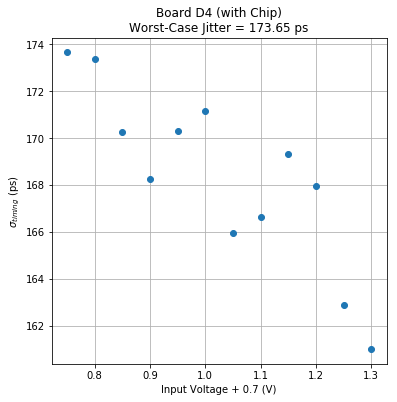

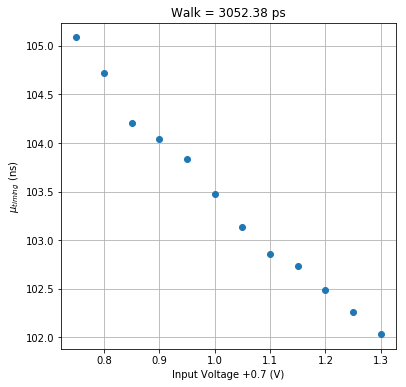

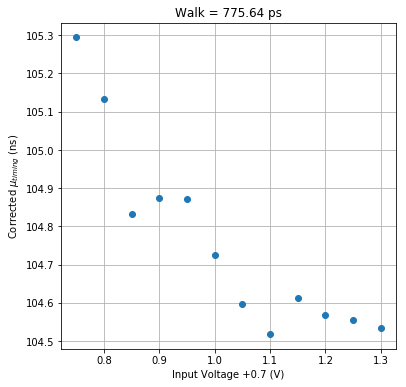

In [201]:
plt.rcParams['figure.figsize'] = (6,6)
plt.rcParams.update({'font.size': 10})

tdiff_corrected = [t-walk_0p7ref_est(vin_vec[i]) for i,t in enumerate(tdiff_avg_vec)]

# idx_worst = np.argmax(tdiff_std_vec)
# vin_worst = vin_vec[idx_worst]
# tdiff_std_worst = np.max(tdiff_std_vec)

plt.plot(vin_vec, [t*1e12 for t in tdiff_std_vec], 'o')
plt.grid(True)
plt.xlabel("Input Voltage + 0.7 (V)")
plt.ylabel("$\sigma_{timing}$ (ps)")
# plt.title(f'Worst-Case Jitter = {round(tdiff_worst*1e12, 2)} ps\nVin={round(vin_worst, 2)}V\n{file_worst}')
plt.title(f'Board D4 (with Chip)\nWorst-Case Jitter = {round(tdiff_worst*1e12, 2)} ps')

plt.figure()
plt.plot(vin_vec, [t*1e9 for t in tdiff_avg_vec], 'o')
plt.grid(True)
plt.xlabel("Input Voltage +0.7 (V)")
plt.ylabel("$\mu_{timing}$ (ns)")
plt.title(f'Walk = {round((max(tdiff_avg_vec)-min(tdiff_avg_vec))*1e12, 2)} ps');

plt.figure()
plt.plot(vin_vec, [t*1e9 for t in tdiff_corrected], 'o')
plt.grid(True)
plt.xlabel("Input Voltage +0.7 (V)");
plt.ylabel("Corrected $\mu_{timing}$ (ns)");
plt.title(f'Walk = {round((max(tdiff_corrected)-min(tdiff_corrected))*1e12, 2)} ps');

<h2>Timing vs. Attenuation Factor</h2>

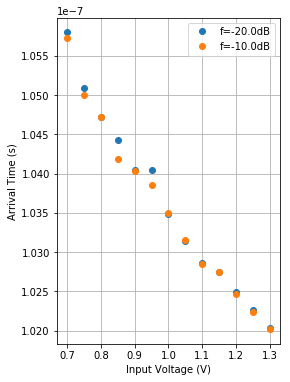

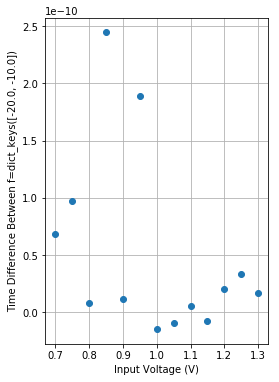

In [115]:
# Plot difference in timing vs. attenuation factor
vin_tdiff_map = {vin:dict(f=[],tdiff=[]) for vin in vin_vec}
atten_tdiff_map = {f:dict(vin=[], tdiff=[]) for f in atten_vec}
for i, f_atten in enumerate(atten_vec):
    vin = vin_vec[i]
    tdiff_avg = tdiff_avg_vec[i]
    vin_tdiff_map[vin]['tdiff'].append(tdiff_avg)
    vin_tdiff_map[vin]['f'].append(f_atten)
    atten_tdiff_map[f_atten]['vin'].append(vin)
    atten_tdiff_map[f_atten]['tdiff'].append(tdiff_avg)

for f_atten, vin_tdiff_restr_map in atten_tdiff_map.items():
    plt.plot(vin_tdiff_restr_map['vin'], vin_tdiff_restr_map['tdiff'], 'o', label=f'f={f_atten}dB')
#     for vin, tdiff_across_atten in vin_tdiff_map.items():
#         xdata.append(vin)
#         ydata.append(max(tdiff_across_atten) - min(tdiff_across_atten))

plt.xlabel('Input Voltage (V)');
plt.ylabel('Arrival Time (s)');
plt.grid(True)
plt.legend()

xdata = []
ydata = []
for vin, atten_tdiff_restr_map in vin_tdiff_map.items():
    xdata.append(vin)
    ydata.append(atten_tdiff_restr_map['tdiff'][0] - atten_tdiff_restr_map['tdiff'][-1])

plt.figure()
plt.plot(xdata, ydata, 'o')
plt.xlabel('Input Voltage (V)');
plt.ylabel(f'Time Difference Between f={atten_tdiff_map.keys()}');
plt.grid(True)

2

<h2>Estimating Bandwidth (First Order)</h2>

In [130]:
fatten = 0.1 # Attenuator factor
tdelay = 13.37e-9 # Coax delay
trise = 100e-12 # Nominal pulse rise time
vdac = (1.8/(1<<9)) * (71)

tcross_real_cfd = lambda v_in, f_atten, t_rise, t_delay: t_delay + v_in*f_atten/(v_in/t_rise)
tcross_real_led = lambda v_in, v_thresh, t_rise: v_thresh/(v_in/t_rise)

for vin in vin_vec:
    tcross_cfd = tcross_real_cfd(vin, fatten, trise, tdelay)
    tcross_led = tcross_real_led(vin, vdac, trise)
    tcross_in = max(tcross_cfd, tcross_led)
    
    

# vcross = 0.4
# v0 = 0

# func_tau = lambda vcross, vin, v0, tcross: -tcross/np.log((vcross-vin)/(v0-vin))
# tau_vec = [func_tau(vcross, vin, v0, tdiff_avg_vec[i]) for i,vin in enumerate(vin_vec)]
# pprint(tau_vec)

# plt.plot(vin_vec, tau_vec, 'o')
# plt.grid(True)
# plt.xlabel('Input Voltage + 0.7V')
# plt.ylabel('First-Order Bandwidth (s)')

[0.75, 0.8, 0.8500000000000001, 0.9000000000000001, 0.9500000000000002, 1.0000000000000002, 1.0500000000000003, 1.1000000000000003, 1.1500000000000004, 1.2000000000000004, 1.2500000000000004, 1.3000000000000005]
[1.0538198327923982e-07, 1.049211319631543e-07, 1.0435747467409628e-07, 1.0418152244161038e-07, 1.039207284188152e-07, 1.0353367183931971e-07, 1.0318523802927354e-07, 1.0285229409599763e-07, 1.0272498529736095e-07, 1.0242971712898494e-07, 1.0219647702023626e-07, 1.0197615416890798e-07]


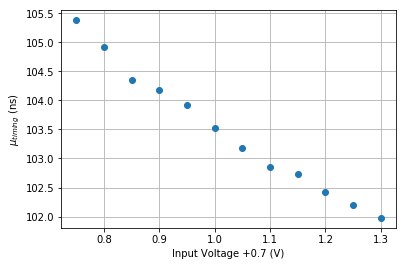

In [135]:
plt.plot(vin_vec, [t*1e9 for t in tdiff_avg_vec], 'o')
plt.grid(True)
plt.xlabel("Input Voltage +0.7 (V)")
plt.ylabel("$\mu_{timing}$ (ns)")
# plt.title(f'Walk = {round((max(tdiff_avg_vec)-min(tdiff_avg_vec))*1e12, 2)} ps');

# tdiff_fit_vec = func_tcross(xdata, *popt)
# plt.plot(vin_vec, [t*1e9 for t in tdiff_fit_vec])
print(vin_vec)
print(tdiff_avg_vec)

<h2>Jitter</h2>

In [58]:
fname = '../../data/testing/20220404_144700_vin0.75V_500x_zcdSmall.yaml'

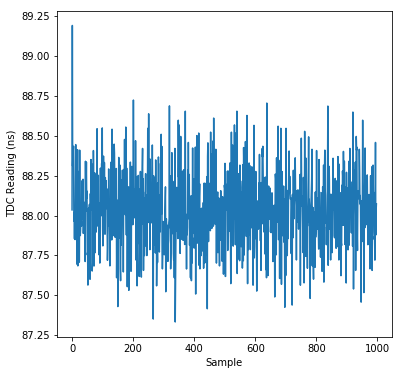

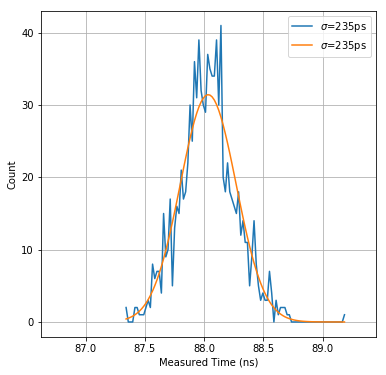

In [145]:
### Looking at the raw data
with open(fname, 'r') as file_in:
    data_raw = yaml.load(file_in, Loader=yaml.UnsafeLoader)
    tdiff_vec = data_raw['data']
    
# Removing the invalid first uninitialized reading
tdiff_vec = [t for t in tdiff_vec if t > 0]
tdiff_vec = [t*1e9/10 for t in tdiff_vec][1:]

# 
plt.plot(tdiff_vec)
plt.xlabel("Sample")
plt.ylabel("TDC Reading (ns)")

# Plotting the raw data
plt.figure()
tdiff_std = np.std(tdiff_vec)
tdiff_vals, tdiff_bins = np.histogram(tdiff_vec, bins=100)
tdiff_bins = 0.5*(tdiff_bins[1:]+tdiff_bins[:-1])
plt.plot(tdiff_bins, tdiff_vals, label=f'$\sigma$={round(tdiff_std*1e3)}ps')
curve_area = np.trapz(tdiff_vals, tdiff_bins)

# Fitting to normal distribution
mu, sigma = stats.norm.fit(tdiff_vec)
fit_gaussian = stats.norm.pdf(tdiff_bins, mu, sigma)
plt.plot(tdiff_bins, fit_gaussian*curve_area, label=f'$\sigma$={round(sigma*1e3)}ps')

plt.xlabel('Measured Time (ns)')
plt.ylabel('Count')
plt.xlim(mu-6*sigma, mu+6*sigma)
plt.grid(True)
plt.legend()

In [142]:
fname = '../../data/testing/20220401_164659_1000x_boardJitter.yaml'

Text(0.5,1,'Board D3 (No Chip)')

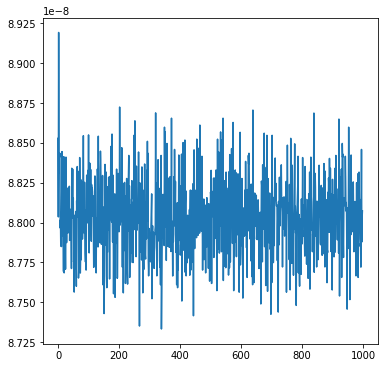

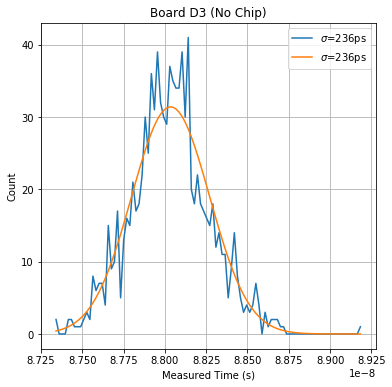

In [148]:
# Getting the raw data
with open(fname, 'r') as file_in:
    data_raw = yaml.load(file_in, Loader=yaml.UnsafeLoader)
    tdiff_vec = data_raw['data']
    
# Removing the invalid first uninitialized reading
tdiff_vec = [t/10 for t in tdiff_vec if t > 0]

# 
plt.plot(tdiff_vec)

# Plotting the raw data
plt.figure()
tdiff_std = np.std(tdiff_vec)
tdiff_vals, tdiff_bins = np.histogram(tdiff_vec, bins=100)
tdiff_bins = 0.5*(tdiff_bins[1:]+tdiff_bins[:-1])
plt.plot(tdiff_bins, tdiff_vals, label=f'$\sigma$={round(tdiff_std*1e12)}ps')
curve_area = np.trapz(tdiff_vals, tdiff_bins)

# Fitting to normal distribution
mu, sigma = stats.norm.fit(tdiff_vec)
fit_gaussian = stats.norm.pdf(tdiff_bins, mu, sigma)
plt.plot(tdiff_bins, fit_gaussian*curve_area, label=f'$\sigma$={round(sigma*1e12)}ps')

plt.xlabel('Measured Time (s)')
plt.ylabel('Count')
plt.grid(True)
plt.legend()
plt.title('Board D3 (No Chip)')

<h1>Full Chain Fast Testing</h1>

In [226]:
fname = '../../data/testing/20220415_154157_vin2.0V_500x_vb0.9V_main.yaml'

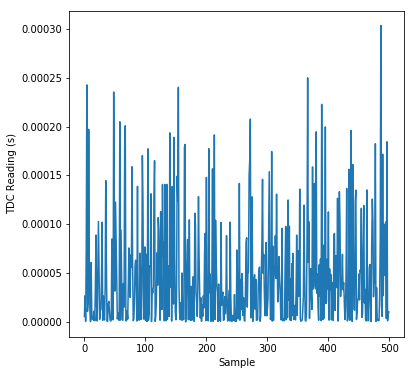

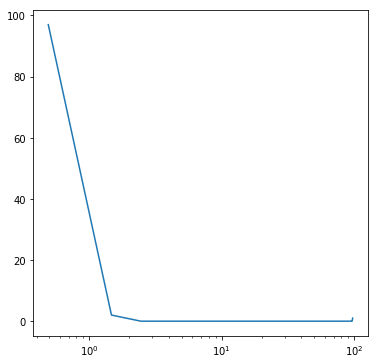

In [232]:
# Getting the raw data
with open(fname, 'r') as file_in:
    data_raw = yaml.load(file_in, Loader=yaml.UnsafeLoader)
    tdiff_vec = data_raw['data']
    
# tdiff_std = np.std(tdiff_vec)
plt.plot(tdiff_vec)
plt.xlabel('Sample')
plt.ylabel('TDC Reading (s)')

plt.figure()
tdiff_vec = [t for t in tdiff_vec if t > 0]
# tdiff_bins = np.logspace(np.log10(min(tdiff_vec)), np.log10(max(tdiff_vec)), 100)
tdiff_vals, tdiff_bins = np.histogram(tdiff_vals, bins=100)
tdiff_bins = 0.5*(tdiff_bins[1:]+tdiff_bins[:-1])
plt.semilogx(tdiff_bins, tdiff_vals)
curve_area = np.trapz(tdiff_vals, tdiff_bins)